In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import pickle

## Load Dataset

In [2]:
X_train = pickle.load(open('../Data/X_train.pkl', 'rb'))
y_train = pickle.load(open('../Data/y_train.pkl', 'rb'))
X_test = pickle.load(open('../Data/X_test.pkl', 'rb'))
y_test = pickle.load(open('../Data/y_test.pkl', 'rb'))

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(329, 20530)
(329,)
(83, 20530)
(83,)


## Standardize Data

In [3]:
# standardize the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print(X_train)

[[-0.48855657  0.12112708 -0.33372349 ...  0.04735987  0.50779996
  -0.02217494]
 [ 0.83092164  1.17948768 -0.33372349 ...  0.18754437  0.77965228
  -0.17205193]
 [-1.861054   -0.69352094 -0.33372349 ... -0.35346398 -2.00005787
   3.63814136]
 ...
 [ 1.50287947  0.88173571  0.1048791  ... -0.33180584  0.91213697
  -0.14253948]
 [-0.06583194  0.60359346 -0.33372349 ...  0.20030191  0.44110666
  -1.31512921]
 [-0.87784052 -0.01478846 -0.33372349 ...  0.12805867  1.46177518
  -0.6430939 ]]


In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [5]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([329, 20530]),
 torch.Size([83, 20530]),
 torch.Size([329]),
 torch.Size([83]))

# Define the model

In [38]:
from tqdm import tqdm

class DLModel(nn.Module):
    def __init__(self, input_size):
        super(DLModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)
    
    def fit(self, X, y, epochs, batch_size, lr):
        criterion = nn.BCELoss()
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        
        for epoch in tqdm(range(epochs)):
        # for epoch in range(epochs):
            for i in range(0, X.shape[0], batch_size):

                X_batch = X[i:i+batch_size]
                y_batch = y[i:i+batch_size]

                y_pred = self(X_batch)
                loss = criterion(y_pred, y_batch.view(-1, 1))

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # print('Epoch: {}, Loss: {}'.format(epoch, loss.item()))

    def predict(self, X):
        y_pred = self(X)
        return y_pred

In [39]:
# model parameters
input_size = 20530
learning_rate = 0.01
epochs = 50
batch_size = 64

In [40]:
model = DLModel(input_size)
model.to(device)
model.fit(X_train, y_train, epochs, batch_size, learning_rate)

100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


In [41]:
from sklearn.metrics import roc_auc_score

# test accuracy
with torch.no_grad():
    y_pred = model.predict(X_test)
    y_pred = y_pred.round()
    acc = y_pred.eq(y_test.view_as(y_pred)).sum() / float(len(y_test))
    print(f'Test accuracy: {acc:.4f}')

# test auc
with torch.no_grad():
    y_pred = model.predict(X_test)
    y_pred = y_pred.round()
    auc = roc_auc_score(y_test, y_pred)
    print(f'Test AUC: {auc:.4f}')

Test accuracy: 0.9036
Test AUC: 0.8927


## Exhaustive search for components of PCA

In [59]:
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA

# model parameters
input_size = 20530
epochs = 10
lr = 0.1
batch_size = 16
components = [5, 10, 20, 50, 100, 200, 300]

# lists to store results
train_accuracy_list = []
test_accuracy_list = []
auc_score_list = []
max_auc = -999
optimal_model = None
optimal_n_components = None
optimal_x_train = None
optimal_x_test = None
optimal_predictions = None

# dataframe to store results
df = pd.DataFrame(columns=['n_components', 'train_accuracy', 'test_accuracy', 'auc_score'])

for n_components in components:

    print(f'Starting n_components: {n_components}')

    pca = PCA(n_components=n_components)
    reduced_X_train = pca.fit_transform(X_train)
    reduced_X_test = pca.transform(X_test)
    reduced_X_train = torch.tensor(reduced_X_train, dtype=torch.float32)
    reduced_X_test = torch.tensor(reduced_X_test, dtype=torch.float32)
    
    model = DLModel(input_size=n_components)
    model.to(device)
    model.fit(reduced_X_train, y_train, epochs, batch_size, lr)

    # train accuracy
    with torch.no_grad():
        y_pred = model.predict(reduced_X_train)
        y_pred = y_pred.round()
        train_acc = y_pred.eq(y_train.view_as(y_pred)).sum() / float(len(y_train))
        train_acc = train_acc.item()
        print(f'Train accuracy: {train_acc:.4f}')

    # test accuracy
    with torch.no_grad():
        y_pred = model.predict(reduced_X_test)
        y_pred = y_pred.round()
        test_acc = y_pred.eq(y_test.view_as(y_pred)).sum() / float(len(y_test))
        test_acc = test_acc.item()
        print(f'Test accuracy: {test_acc:.4f}')

    # test auc
    with torch.no_grad():
        y_pred = model.predict(reduced_X_test)
        y_pred = y_pred.round()
        test_auc = roc_auc_score(y_test, y_pred)
        print(f'Test AUC: {test_auc:.4f}')

    train_accuracy_list.append(train_acc)
    test_accuracy_list.append(test_acc)
    auc_score_list.append(test_auc)

    if test_auc > max_auc:
        max_auc = test_auc
        optimal_model = model
        optimal_n_components = n_components
        optimal_x_train = reduced_X_train
        optimal_x_test = reduced_X_test
        optimal_predictions = y_pred

    df = pd.concat([df, pd.DataFrame([[n_components, train_acc, test_acc, test_auc]], columns=['n_components', 'train_accuracy', 'test_accuracy', 'auc_score'])])
    print()

Starting n_components: 5


100%|██████████| 10/10 [00:00<00:00, 22.59it/s]


Train accuracy: 0.9818
Test accuracy: 0.8916
Test AUC: 0.8377

Starting n_components: 10


100%|██████████| 10/10 [00:00<00:00, 21.20it/s]


Train accuracy: 0.9970
Test accuracy: 0.8916
Test AUC: 0.8377

Starting n_components: 20


100%|██████████| 10/10 [00:00<00:00, 22.15it/s]


Train accuracy: 0.9970
Test accuracy: 0.9036
Test AUC: 0.8689

Starting n_components: 50


100%|██████████| 10/10 [00:00<00:00, 20.61it/s]


Train accuracy: 1.0000
Test accuracy: 0.9036
Test AUC: 0.8927

Starting n_components: 100


100%|██████████| 10/10 [00:00<00:00, 20.84it/s]


Train accuracy: 1.0000
Test accuracy: 0.9277
Test AUC: 0.9314

Starting n_components: 200


100%|██████████| 10/10 [00:00<00:00, 19.19it/s]


Train accuracy: 1.0000
Test accuracy: 0.9277
Test AUC: 0.9552

Starting n_components: 300


100%|██████████| 10/10 [00:00<00:00, 17.13it/s]

Train accuracy: 1.0000
Test accuracy: 0.9639
Test AUC: 0.9776



In [60]:
# extract the rows of best 5 auc
best_5_auc = df.nlargest(5, 'auc_score')
best_5_auc

,n_components,train_accuracy,test_accuracy,auc_score
0,300,1.00000,0.963855,0.977612
0,200,1.00000,0.927711,0.955224
0,100,1.00000,0.927711,0.931437
0,50,1.00000,0.903614,0.892724
0,20,0.99696,0.903614,0.868937


In [65]:
df.to_csv('PCA_DL_results.csv', index=False)

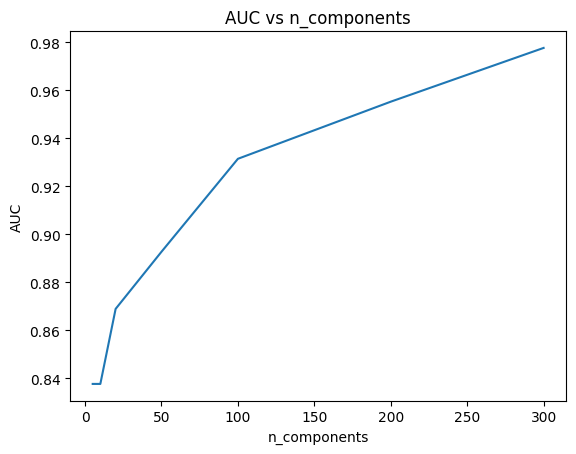

In [62]:
# plot auc vs n_components
import matplotlib.pyplot as plt

plt.plot(components, auc_score_list)
plt.xlabel('n_components')
plt.ylabel('AUC')
plt.title('AUC vs n_components')
plt.show()

### Let's try on a more granular level in the range of 250 to 329

In [63]:
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA

# model parameters
input_size = 20530
epochs = 10
lr = 0.1
batch_size = 16
components = np.arange(250, X_train.shape[0])

# lists to store results
train_accuracy_list = []
test_accuracy_list = []
auc_score_list = []
max_auc = -999
optimal_model = None
optimal_n_components = None
optimal_x_train = None
optimal_x_test = None
optimal_predictions = None

for n_components in components:

    print(f'Starting n_components: {n_components}')

    pca = PCA(n_components=n_components)
    reduced_X_train = pca.fit_transform(X_train)
    reduced_X_test = pca.transform(X_test)
    reduced_X_train = torch.tensor(reduced_X_train, dtype=torch.float32)
    reduced_X_test = torch.tensor(reduced_X_test, dtype=torch.float32)
    
    model = DLModel(input_size=n_components)
    model.to(device)
    model.fit(reduced_X_train, y_train, epochs, batch_size, lr)

    # train accuracy
    with torch.no_grad():
        y_pred = model.predict(reduced_X_train)
        y_pred = y_pred.round()
        train_acc = y_pred.eq(y_train.view_as(y_pred)).sum() / float(len(y_train))
        train_acc = train_acc.item()
        print(f'Train accuracy: {train_acc:.4f}')

    # test accuracy
    with torch.no_grad():
        y_pred = model.predict(reduced_X_test)
        y_pred = y_pred.round()
        test_acc = y_pred.eq(y_test.view_as(y_pred)).sum() / float(len(y_test))
        test_acc = test_acc.item()
        print(f'Test accuracy: {test_acc:.4f}')

    # test auc
    with torch.no_grad():
        y_pred = model.predict(reduced_X_test)
        y_pred = y_pred.round()
        test_auc = roc_auc_score(y_test, y_pred)
        print(f'Test AUC: {test_auc:.4f}')

    train_accuracy_list.append(train_acc)
    test_accuracy_list.append(test_acc)
    auc_score_list.append(test_auc)

    if test_auc > max_auc:
        max_auc = test_auc
        optimal_model = model
        optimal_n_components = n_components
        optimal_x_train = reduced_X_train
        optimal_x_test = reduced_X_test
        optimal_predictions = y_pred

    df = pd.concat([df, pd.DataFrame([[n_components, train_acc, test_acc, test_auc]], columns=['n_components', 'train_accuracy', 'test_accuracy', 'auc_score'])])
    print()

Starting n_components: 250


100%|██████████| 10/10 [00:00<00:00, 16.50it/s]


Train accuracy: 1.0000
Test accuracy: 0.9277
Test AUC: 0.9076

Starting n_components: 251


100%|██████████| 10/10 [00:00<00:00, 17.33it/s]


Train accuracy: 1.0000
Test accuracy: 0.9277
Test AUC: 0.9076

Starting n_components: 252


100%|██████████| 10/10 [00:00<00:00, 17.38it/s]


Train accuracy: 1.0000
Test accuracy: 0.9639
Test AUC: 0.9776

Starting n_components: 253


100%|██████████| 10/10 [00:00<00:00, 17.88it/s]


Train accuracy: 1.0000
Test accuracy: 0.9398
Test AUC: 0.9151

Starting n_components: 254


100%|██████████| 10/10 [00:00<00:00, 17.54it/s]


Train accuracy: 1.0000
Test accuracy: 0.9518
Test AUC: 0.9701

Starting n_components: 255


100%|██████████| 10/10 [00:00<00:00, 16.16it/s]


Train accuracy: 1.0000
Test accuracy: 0.9277
Test AUC: 0.9314

Starting n_components: 256


100%|██████████| 10/10 [00:00<00:00, 18.98it/s]


Train accuracy: 1.0000
Test accuracy: 0.9277
Test AUC: 0.9076

Starting n_components: 257


100%|██████████| 10/10 [00:00<00:00, 20.39it/s]


Train accuracy: 1.0000
Test accuracy: 0.9398
Test AUC: 0.9389

Starting n_components: 258


100%|██████████| 10/10 [00:00<00:00, 15.84it/s]


Train accuracy: 1.0000
Test accuracy: 0.9398
Test AUC: 0.9151

Starting n_components: 259


100%|██████████| 10/10 [00:00<00:00, 18.10it/s]


Train accuracy: 1.0000
Test accuracy: 0.9639
Test AUC: 0.9776

Starting n_components: 260


100%|██████████| 10/10 [00:00<00:00, 16.94it/s]


Train accuracy: 1.0000
Test accuracy: 0.9157
Test AUC: 0.9002

Starting n_components: 261


100%|██████████| 10/10 [00:00<00:00, 18.66it/s]


Train accuracy: 1.0000
Test accuracy: 0.9518
Test AUC: 0.9701

Starting n_components: 262


100%|██████████| 10/10 [00:00<00:00, 18.52it/s]


Train accuracy: 1.0000
Test accuracy: 0.9398
Test AUC: 0.9389

Starting n_components: 263


100%|██████████| 10/10 [00:00<00:00, 17.42it/s]


Train accuracy: 1.0000
Test accuracy: 0.9157
Test AUC: 0.9002

Starting n_components: 264


100%|██████████| 10/10 [00:00<00:00, 18.26it/s]


Train accuracy: 1.0000
Test accuracy: 0.9277
Test AUC: 0.9314

Starting n_components: 265


100%|██████████| 10/10 [00:00<00:00, 17.34it/s]


Train accuracy: 1.0000
Test accuracy: 0.9157
Test AUC: 0.9240

Starting n_components: 266


100%|██████████| 10/10 [00:00<00:00, 17.58it/s]


Train accuracy: 1.0000
Test accuracy: 0.9277
Test AUC: 0.9076

Starting n_components: 267


100%|██████████| 10/10 [00:00<00:00, 16.80it/s]


Train accuracy: 1.0000
Test accuracy: 0.9398
Test AUC: 0.9389

Starting n_components: 268


100%|██████████| 10/10 [00:00<00:00, 16.78it/s]


Train accuracy: 1.0000
Test accuracy: 0.9277
Test AUC: 0.9314

Starting n_components: 269


100%|██████████| 10/10 [00:00<00:00, 16.88it/s]


Train accuracy: 1.0000
Test accuracy: 0.9398
Test AUC: 0.9389

Starting n_components: 270


100%|██████████| 10/10 [00:00<00:00, 16.91it/s]


Train accuracy: 1.0000
Test accuracy: 0.9277
Test AUC: 0.9076

Starting n_components: 271


100%|██████████| 10/10 [00:00<00:00, 16.64it/s]


Train accuracy: 1.0000
Test accuracy: 0.9398
Test AUC: 0.9627

Starting n_components: 272


100%|██████████| 10/10 [00:00<00:00, 16.76it/s]


Train accuracy: 1.0000
Test accuracy: 0.9277
Test AUC: 0.9314

Starting n_components: 273


100%|██████████| 10/10 [00:00<00:00, 16.52it/s]


Train accuracy: 1.0000
Test accuracy: 0.9518
Test AUC: 0.9701

Starting n_components: 274


100%|██████████| 10/10 [00:00<00:00, 16.23it/s]


Train accuracy: 1.0000
Test accuracy: 0.9036
Test AUC: 0.8927

Starting n_components: 275


100%|██████████| 10/10 [00:00<00:00, 15.73it/s]


Train accuracy: 1.0000
Test accuracy: 0.9398
Test AUC: 0.9389

Starting n_components: 276


100%|██████████| 10/10 [00:00<00:00, 15.10it/s]


Train accuracy: 1.0000
Test accuracy: 0.9398
Test AUC: 0.9389

Starting n_components: 277


100%|██████████| 10/10 [00:00<00:00, 15.44it/s]


Train accuracy: 1.0000
Test accuracy: 0.9277
Test AUC: 0.9314

Starting n_components: 278


100%|██████████| 10/10 [00:00<00:00, 15.68it/s]


Train accuracy: 1.0000
Test accuracy: 0.9277
Test AUC: 0.9314

Starting n_components: 279


100%|██████████| 10/10 [00:00<00:00, 14.22it/s]


Train accuracy: 1.0000
Test accuracy: 0.9277
Test AUC: 0.8839

Starting n_components: 280


100%|██████████| 10/10 [00:00<00:00, 13.69it/s]


Train accuracy: 1.0000
Test accuracy: 0.9277
Test AUC: 0.9076

Starting n_components: 281


100%|██████████| 10/10 [00:00<00:00, 12.25it/s]


Train accuracy: 1.0000
Test accuracy: 0.9398
Test AUC: 0.9389

Starting n_components: 282


100%|██████████| 10/10 [00:00<00:00, 11.63it/s]


Train accuracy: 1.0000
Test accuracy: 0.9398
Test AUC: 0.9389

Starting n_components: 283


100%|██████████| 10/10 [00:00<00:00, 12.41it/s]


Train accuracy: 1.0000
Test accuracy: 0.9518
Test AUC: 0.9701

Starting n_components: 284


100%|██████████| 10/10 [00:00<00:00, 17.23it/s]


Train accuracy: 1.0000
Test accuracy: 0.9277
Test AUC: 0.9314

Starting n_components: 285


100%|██████████| 10/10 [00:00<00:00, 13.79it/s]


Train accuracy: 1.0000
Test accuracy: 0.9518
Test AUC: 0.9464

Starting n_components: 286


100%|██████████| 10/10 [00:00<00:00, 16.85it/s]


Train accuracy: 1.0000
Test accuracy: 0.9518
Test AUC: 0.9464

Starting n_components: 287


100%|██████████| 10/10 [00:00<00:00, 17.21it/s]


Train accuracy: 1.0000
Test accuracy: 0.9518
Test AUC: 0.9464

Starting n_components: 288


100%|██████████| 10/10 [00:00<00:00, 15.71it/s]


Train accuracy: 1.0000
Test accuracy: 0.9277
Test AUC: 0.9314

Starting n_components: 289


100%|██████████| 10/10 [00:00<00:00, 16.06it/s]


Train accuracy: 1.0000
Test accuracy: 0.9398
Test AUC: 0.9389

Starting n_components: 290


100%|██████████| 10/10 [00:00<00:00, 16.21it/s]


Train accuracy: 1.0000
Test accuracy: 0.9518
Test AUC: 0.9701

Starting n_components: 291


100%|██████████| 10/10 [00:00<00:00, 15.51it/s]


Train accuracy: 1.0000
Test accuracy: 0.9518
Test AUC: 0.9464

Starting n_components: 292


100%|██████████| 10/10 [00:00<00:00, 16.47it/s]


Train accuracy: 1.0000
Test accuracy: 0.9398
Test AUC: 0.9389

Starting n_components: 293


100%|██████████| 10/10 [00:00<00:00, 16.69it/s]


Train accuracy: 1.0000
Test accuracy: 0.9398
Test AUC: 0.9389

Starting n_components: 294


100%|██████████| 10/10 [00:00<00:00, 16.98it/s]


Train accuracy: 1.0000
Test accuracy: 0.9277
Test AUC: 0.9314

Starting n_components: 295


100%|██████████| 10/10 [00:00<00:00, 16.28it/s]


Train accuracy: 1.0000
Test accuracy: 0.9398
Test AUC: 0.9627

Starting n_components: 296


100%|██████████| 10/10 [00:00<00:00, 16.55it/s]


Train accuracy: 1.0000
Test accuracy: 0.9518
Test AUC: 0.9701

Starting n_components: 297


100%|██████████| 10/10 [00:00<00:00, 16.04it/s]


Train accuracy: 1.0000
Test accuracy: 0.9398
Test AUC: 0.9389

Starting n_components: 298


100%|██████████| 10/10 [00:00<00:00, 16.26it/s]


Train accuracy: 1.0000
Test accuracy: 0.9398
Test AUC: 0.9389

Starting n_components: 299


100%|██████████| 10/10 [00:00<00:00, 15.13it/s]


Train accuracy: 1.0000
Test accuracy: 0.9518
Test AUC: 0.9464

Starting n_components: 300


100%|██████████| 10/10 [00:00<00:00, 16.45it/s]


Train accuracy: 1.0000
Test accuracy: 0.9518
Test AUC: 0.9464

Starting n_components: 301


100%|██████████| 10/10 [00:00<00:00, 16.74it/s]


Train accuracy: 1.0000
Test accuracy: 0.9518
Test AUC: 0.9464

Starting n_components: 302


100%|██████████| 10/10 [00:00<00:00, 15.43it/s]


Train accuracy: 1.0000
Test accuracy: 0.9518
Test AUC: 0.9701

Starting n_components: 303


100%|██████████| 10/10 [00:00<00:00, 14.72it/s]


Train accuracy: 1.0000
Test accuracy: 0.9518
Test AUC: 0.9464

Starting n_components: 304


100%|██████████| 10/10 [00:00<00:00, 14.90it/s]


Train accuracy: 1.0000
Test accuracy: 0.9518
Test AUC: 0.9701

Starting n_components: 305


100%|██████████| 10/10 [00:00<00:00, 15.12it/s]


Train accuracy: 1.0000
Test accuracy: 0.9398
Test AUC: 0.9389

Starting n_components: 306


100%|██████████| 10/10 [00:00<00:00, 14.68it/s]


Train accuracy: 1.0000
Test accuracy: 0.9398
Test AUC: 0.9389

Starting n_components: 307


100%|██████████| 10/10 [00:00<00:00, 15.35it/s]


Train accuracy: 1.0000
Test accuracy: 0.9518
Test AUC: 0.9464

Starting n_components: 308


100%|██████████| 10/10 [00:00<00:00, 14.59it/s]


Train accuracy: 1.0000
Test accuracy: 0.9398
Test AUC: 0.9389

Starting n_components: 309


100%|██████████| 10/10 [00:00<00:00, 15.34it/s]


Train accuracy: 1.0000
Test accuracy: 0.9518
Test AUC: 0.9464

Starting n_components: 310


100%|██████████| 10/10 [00:00<00:00, 14.10it/s]


Train accuracy: 1.0000
Test accuracy: 0.9398
Test AUC: 0.9389

Starting n_components: 311


100%|██████████| 10/10 [00:00<00:00, 15.00it/s]


Train accuracy: 1.0000
Test accuracy: 0.9639
Test AUC: 0.9776

Starting n_components: 312


100%|██████████| 10/10 [00:00<00:00, 14.29it/s]


Train accuracy: 1.0000
Test accuracy: 0.9277
Test AUC: 0.9076

Starting n_components: 313


100%|██████████| 10/10 [00:00<00:00, 14.52it/s]


Train accuracy: 1.0000
Test accuracy: 0.9398
Test AUC: 0.9389

Starting n_components: 314


100%|██████████| 10/10 [00:00<00:00, 14.01it/s]


Train accuracy: 1.0000
Test accuracy: 0.9518
Test AUC: 0.9464

Starting n_components: 315


100%|██████████| 10/10 [00:00<00:00, 13.95it/s]


Train accuracy: 1.0000
Test accuracy: 0.9398
Test AUC: 0.9389

Starting n_components: 316


100%|██████████| 10/10 [00:00<00:00, 15.17it/s]


Train accuracy: 1.0000
Test accuracy: 0.9277
Test AUC: 0.9552

Starting n_components: 317


100%|██████████| 10/10 [00:00<00:00, 14.82it/s]


Train accuracy: 1.0000
Test accuracy: 0.9277
Test AUC: 0.9314

Starting n_components: 318


100%|██████████| 10/10 [00:00<00:00, 14.48it/s]


Train accuracy: 1.0000
Test accuracy: 0.9398
Test AUC: 0.9389

Starting n_components: 319


100%|██████████| 10/10 [00:00<00:00, 14.78it/s]


Train accuracy: 1.0000
Test accuracy: 0.9518
Test AUC: 0.9464

Starting n_components: 320


100%|██████████| 10/10 [00:00<00:00, 14.49it/s]


Train accuracy: 1.0000
Test accuracy: 0.9518
Test AUC: 0.9701

Starting n_components: 321


100%|██████████| 10/10 [00:00<00:00, 12.85it/s]


Train accuracy: 1.0000
Test accuracy: 0.9518
Test AUC: 0.9701

Starting n_components: 322


100%|██████████| 10/10 [00:00<00:00, 14.62it/s]


Train accuracy: 1.0000
Test accuracy: 0.9398
Test AUC: 0.9389

Starting n_components: 323


100%|██████████| 10/10 [00:00<00:00, 13.47it/s]


Train accuracy: 1.0000
Test accuracy: 0.9518
Test AUC: 0.9464

Starting n_components: 324


100%|██████████| 10/10 [00:00<00:00, 13.30it/s]


Train accuracy: 1.0000
Test accuracy: 0.9518
Test AUC: 0.9464

Starting n_components: 325


100%|██████████| 10/10 [00:00<00:00, 15.39it/s]


Train accuracy: 1.0000
Test accuracy: 0.9518
Test AUC: 0.9701

Starting n_components: 326


100%|██████████| 10/10 [00:00<00:00, 14.10it/s]


Train accuracy: 1.0000
Test accuracy: 0.9518
Test AUC: 0.9464

Starting n_components: 327


100%|██████████| 10/10 [00:00<00:00, 14.96it/s]


Train accuracy: 1.0000
Test accuracy: 0.9518
Test AUC: 0.9701

Starting n_components: 328


100%|██████████| 10/10 [00:00<00:00, 15.55it/s]

Train accuracy: 1.0000
Test accuracy: 0.9639
Test AUC: 0.9776



In [64]:
# extract the rows of best 5 auc
best_5_auc = df.nlargest(5, 'auc_score')
best_5_auc

,n_components,train_accuracy,test_accuracy,auc_score
0,300,1.0,0.963855,0.977612
0,252,1.0,0.963855,0.977612
0,259,1.0,0.963855,0.977612
0,311,1.0,0.963855,0.977612
0,328,1.0,0.963855,0.977612


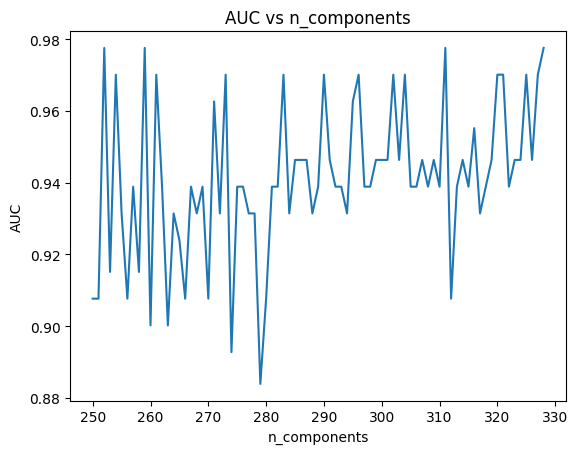

In [66]:
# plot auc vs n_components
import matplotlib.pyplot as plt

plt.plot(components, auc_score_list)
plt.xlabel('n_components')
plt.ylabel('AUC')
plt.title('AUC vs n_components')
plt.show()

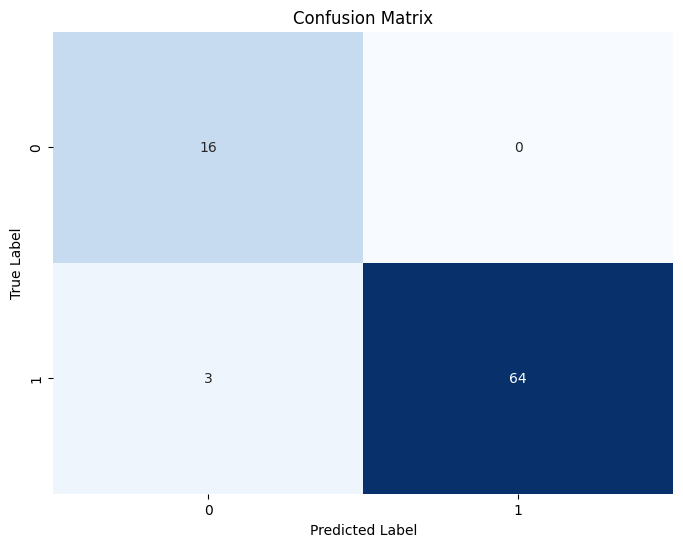

,precision,recall,f1-score,support
0.0,0.842105,1.000000,0.914286,16.000000
1.0,1.000000,0.955224,0.977099,67.000000
accuracy,0.963855,0.963855,0.963855,0.963855
macro avg,0.921053,0.977612,0.945692,83.000000
weighted avg,0.969562,0.963855,0.964991,83.000000


In [68]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# plot confusion matrix
cm = confusion_matrix(y_test, optimal_predictions)
plt.figure(figsize=(8, 6))
plt.title("Confusion Matrix")
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# print classification report as a df
cr = classification_report(y_test, optimal_predictions, output_dict=True)
cr_df = pd.DataFrame(cr).transpose()
cr_df